---
# pRF Viewer

This notebook shows you how to read in the `pickle`-files that are generated by the line-scanning code. It shows you how to view the results on the surface using `pycortex`, plot specific pRFs/timecourses from vertices, and how to obtain size-response functions

In [1]:
import fmriproc
from fmriproc import prf
from lazyfmri import plotting
from cxutils import optimal
import os
import matplotlib.pyplot as plt
opj = os.path.join

/Users/heij/miniconda3/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
os.environ.get("CTX")

'/Users/heij/git/openfmri/pRF/derivatives/pycortex'

The files produced by the line-scanning repository will generally live in `$DIR_DATA_DERIV/prf/<sub>/ses-<ses>`. You can specify the specific folders below, as well as particular subject settings (e.g., subject ID, session ID, task ID, and repetition time). It will then look for the following: 

- BOLD data (a `npy`-file ending on `_hemi-LR_desc-avg_bold.npy`, should live in the prf directory)
- Design matrix (a `mat`-file called `design_task-<taskID>`, should live in the prf directory)
- Model files (`pkl`-files containing `model-` flags in the filename)

In [3]:
# define project directory
# proj_dir = "/data1/projects/MicroFunc/Zoey/projects"
# proj_name = "pilot1"
proj_dir = "/Users/heij/git/openfmri" 
proj_name = "pRF"
deriv = opj(proj_dir, proj_name, "derivatives")

# define subject settings
sub = "006"
ses = "1"
task = "2R"
TR = 1.5

# find BOLD data
prf_dir = opj(deriv, "prf", f"sub-{sub}", f"ses-{ses}")
bold_file = opj(prf_dir, f"sub-{sub}_ses-{ses}_task-{task}_hemi-LR_desc-avg_bold.npy")
print(f"BOLD:\t{bold_file}")
dm_file = opj(prf_dir, f"design_task-{task}.mat")
print(f"Design:\t{dm_file}")
# find model files
model_files = {}
for model in ["gauss","norm","css","dog"]:
    pkl_file = opj(prf_dir, f"sub-{sub}_ses-{ses}_task-{task}_model-{model}_stage-iter_desc-prf_params.pkl")
    if os.path.exists(pkl_file):
        model_files[model] = pkl_file

for key,val in model_files.items():
    print(f"{key}:\t{val}")

BOLD:	/Users/heij/git/openfmri/pRF/derivatives/prf/sub-006/ses-1/sub-006_ses-1_task-2R_hemi-LR_desc-avg_bold.npy
Design:	/Users/heij/git/openfmri/pRF/derivatives/prf/sub-006/ses-1/design_task-2R.mat
gauss:	/Users/heij/git/openfmri/pRF/derivatives/prf/sub-006/ses-1/sub-006_ses-1_task-2R_model-gauss_stage-iter_desc-prf_params.pkl
norm:	/Users/heij/git/openfmri/pRF/derivatives/prf/sub-006/ses-1/sub-006_ses-1_task-2R_model-norm_stage-iter_desc-prf_params.pkl


In [4]:
!call_ctxfilestore show_fs

/Users/heij/git/openfmri/pRF/derivatives/pycortex


Using `linescanning.optimal.pRFCalc`, we can quickly parse the pRF-estimates into a dataframe given the model-type (e.g., `norm`). This class then also created `pycortex` objects than can be opened by calling `.open_pycortex()`. For some reason, this seems to work better if your default browser is Chrome. The function will spit out colorbars for the different elements (`r2`, `eccentricity`, and `polar angle`), as well as the vertex ID with the highest variance explained.

In [4]:
%matplotlib inline
check_model = "norm"

# plot parameters on surface
skip_ctx = False
prf_obj = optimal.pRFCalc(model_files[check_model], skip_cortex=skip_ctx)

Started server on port 47358
max r2 = 0.93 | vert = 335099


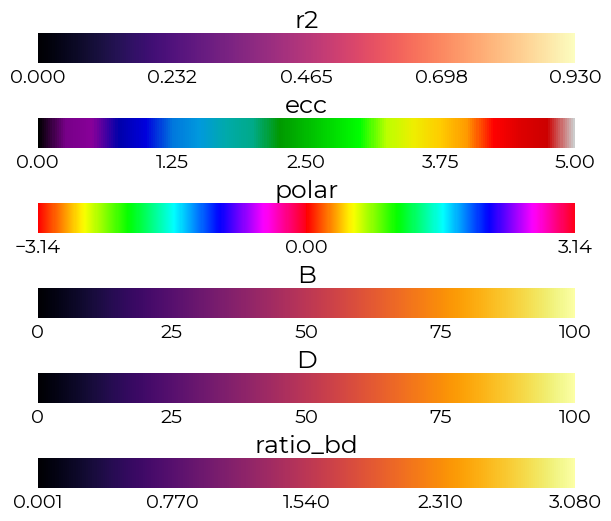

In [10]:

if not skip_ctx:
    prf_obj.open_pycortex(
        fig_dir=opj(os.path.dirname(dm_file), "cmap_test"),
        base_name="sub-006_cmap-uint"
    )

print(f"max r2 = {round(prf_obj.max_r2,2)} | vert = {prf_obj.max_r2_vert}")

saving r2
saving ecc
saving polar
saving B
saving D
saving ratio_bd
saving /Users/heij/git/openfmri/pRF/derivatives/prf/sub-006/ses-1/cmap_test/sub-006_cmap-uint_desc-brainmaps.pdf


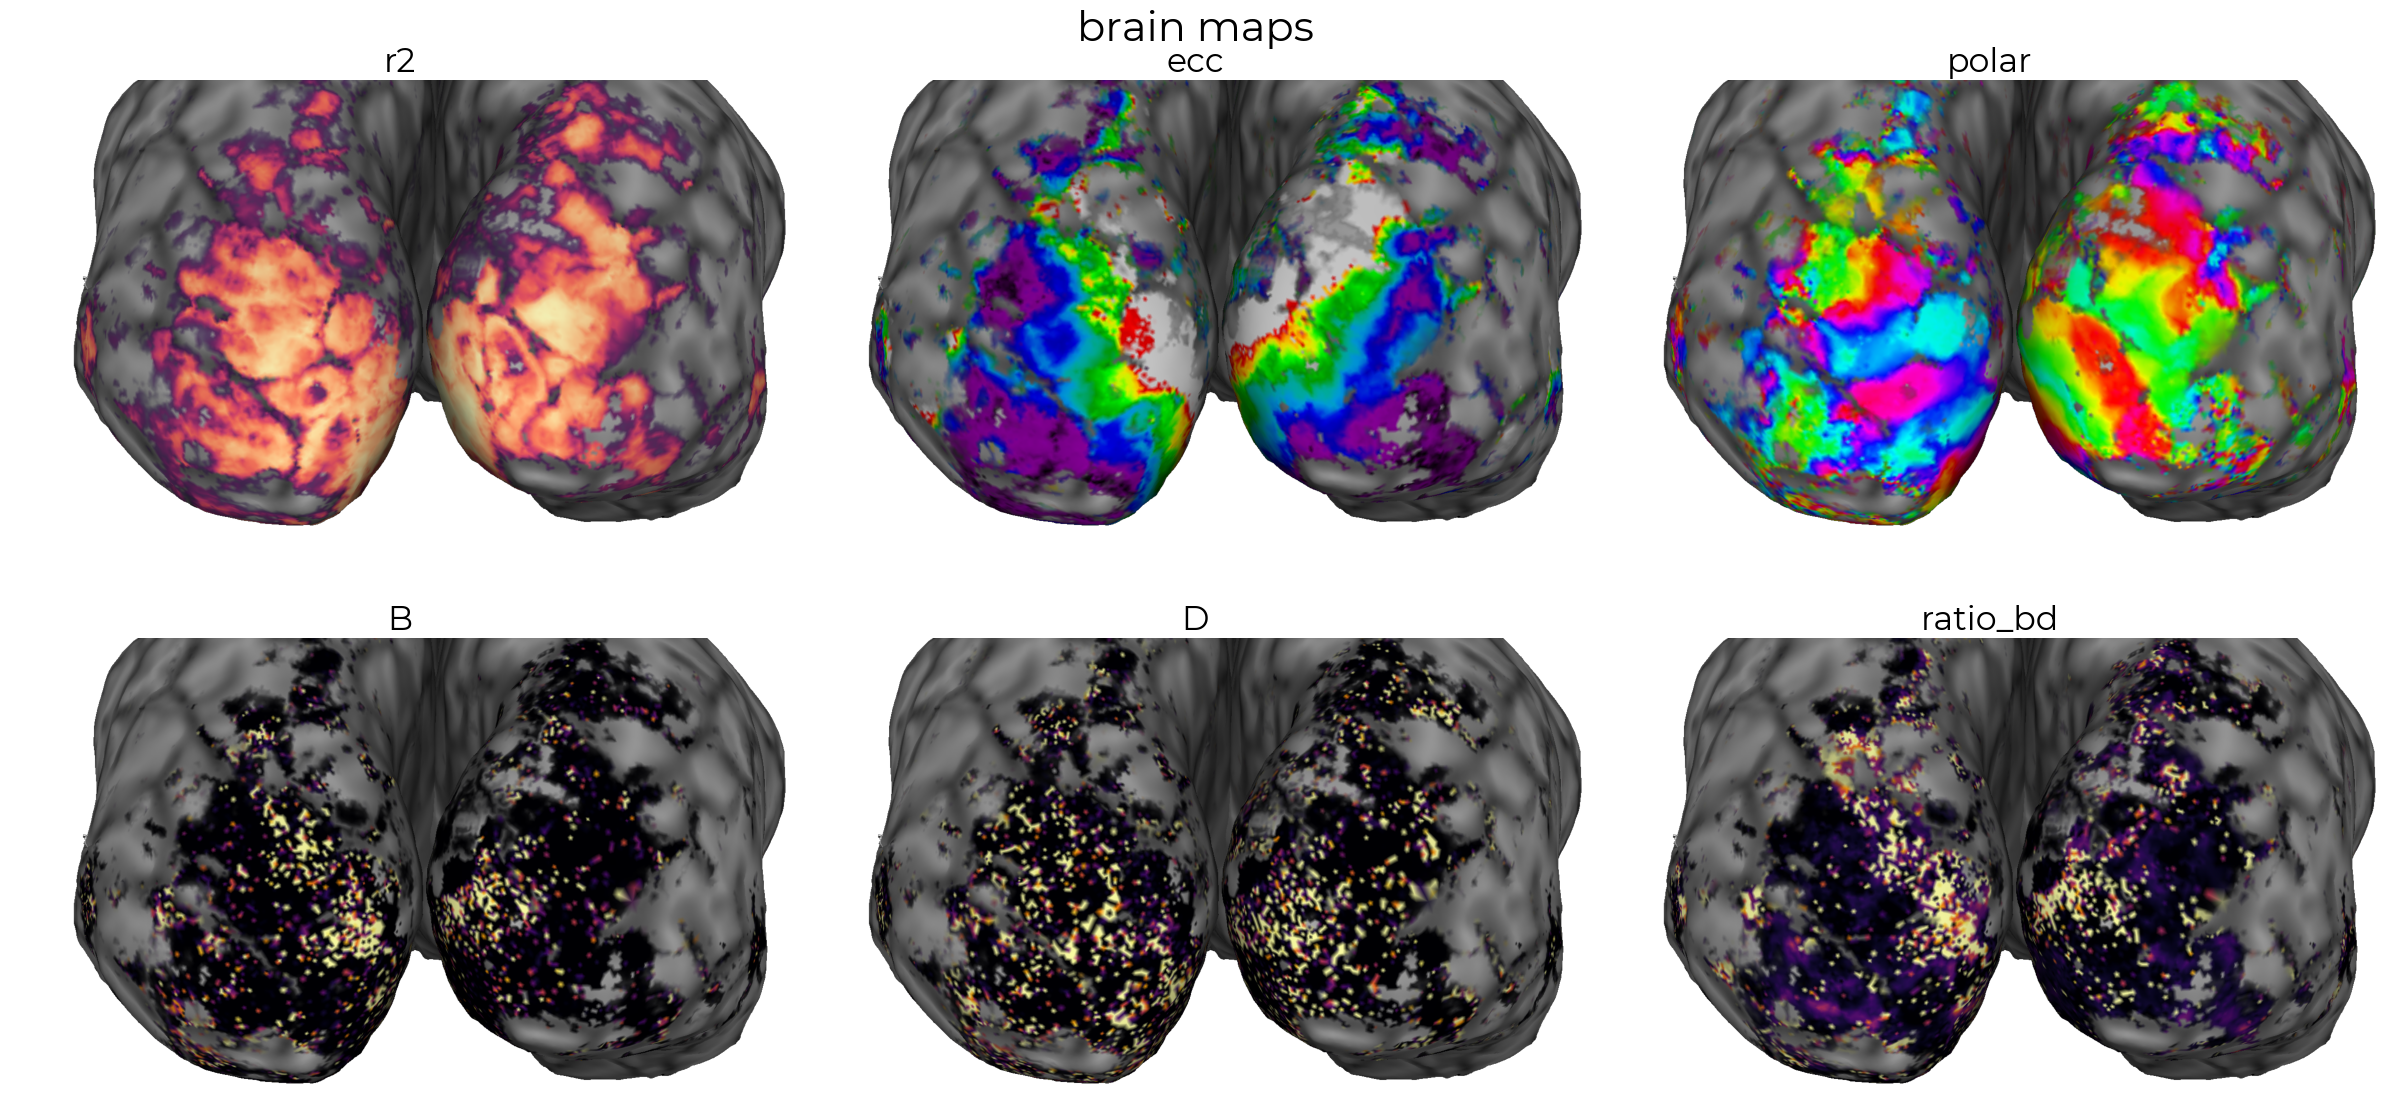

In [11]:
prf_obj.pyc.save_all(gallery=True)

In [12]:
# load_params function can deal with this type of dictionary input
model_files

{'gauss': '/Users/heij/git/openfmri/pRF/derivatives/prf/sub-006/ses-1/sub-006_ses-1_task-2R_model-gauss_stage-iter_desc-prf_params.pkl',
 'norm': '/Users/heij/git/openfmri/pRF/derivatives/prf/sub-006/ses-1/sub-006_ses-1_task-2R_model-norm_stage-iter_desc-prf_params.pkl'}

We can then load in the data/models using the `linescanning.prf.pRFmodelFitting` class (see also the `pRFmodelFItting`-notebook). This class accepts the dictionary-like input printed above, and loads them in as `<model>_iter`, which stands for the iterative search parameters of a specified model. This we can then use when calling the `plot_vox()` function below.

In [13]:
# initiate object
obj = prf.pRFmodelFitting(
    bold_file,
    design_matrix=dm_file,
    TR=TR,
    model=check_model,
    verbose=True,
)

# load parameters
obj.load_params(
    model_files, 
    stage="iter",
    model=None
)

Reading design matrix from '/Users/heij/git/openfmri/pRF/derivatives/prf/sub-006/ses-1/design_task-2R.mat'
Reading data from '/Users/heij/git/openfmri/pRF/derivatives/prf/sub-006/ses-1/sub-006_ses-1_task-2R_hemi-LR_desc-avg_bold.npy'
Skipped volumes was negative (-345303), transposing data to (345528, 221)
Design has 4 more volumes than timecourses, trimming from beginning of design to (100, 100, 221)
Reading settings from '/Users/heij/miniconda3/lib/python3.9/site-packages/fmriproc/misc/prf_analysis.yml'

---------------------------------------------------------------------------------------------------
Check these important settings!
 Screen distance: 196cm
 Screen size: 39.3cm
 TR: 1.5s
---------------------------------------------------------------------------------------------------

Instantiate HRF with: [1, 1, 0] (fit=True)
Using constraint(s): ['tc', 'tc'] (gauss | extended)
Reading settings from '/Users/heij/git/openfmri/pRF/derivatives/prf/sub-006/ses-1/sub-006_ses-1_task-2R_

Here we can choose to plot the pRF and the timecourse (data+prediction) of a given vertex, with the model of our choosing. Here we choose `norm`, which represents the divisive-normalization model. If you have other models in the `model_files`-dictionary, you can specify those here to see how the prediction changes based on selected model

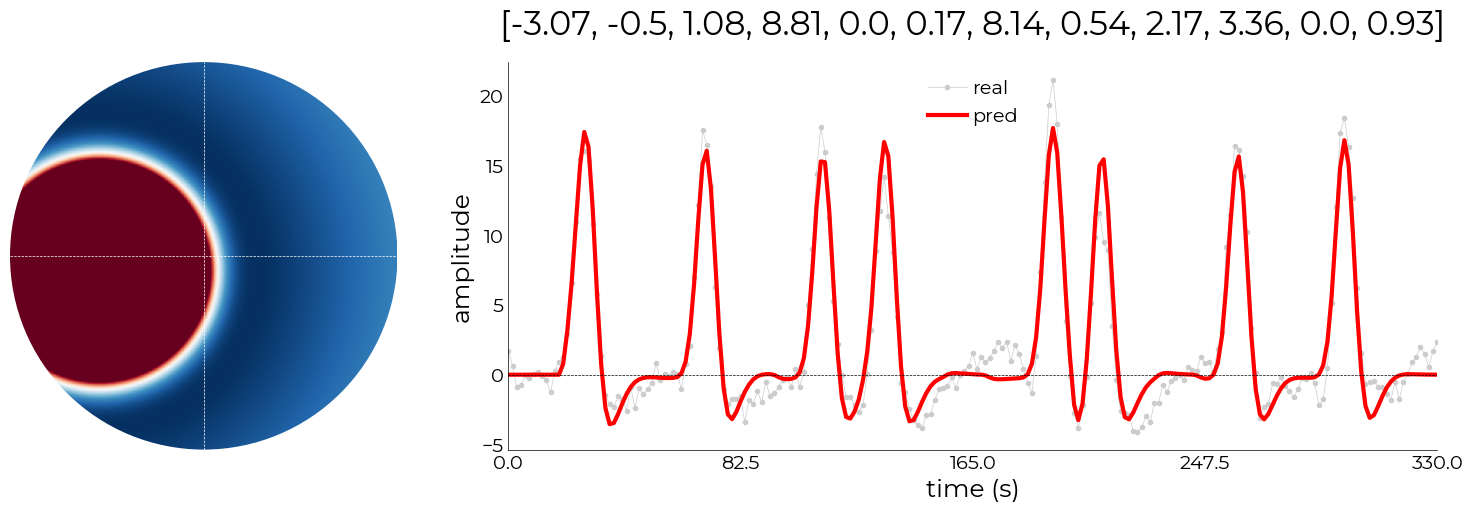

In [14]:
%matplotlib inline
plot_vert = prf_obj.max_r2_vert
_ = obj.plot_vox(vox_nr=plot_vert, model="norm", title="pars")

The DN-model allows for modeling of the response of pRFs given a certain stimulus size, as it's able to capture both non-linearities as the beginning of the curve and at the end.

 Max stimulation @1.89dva | ampl = 36.12


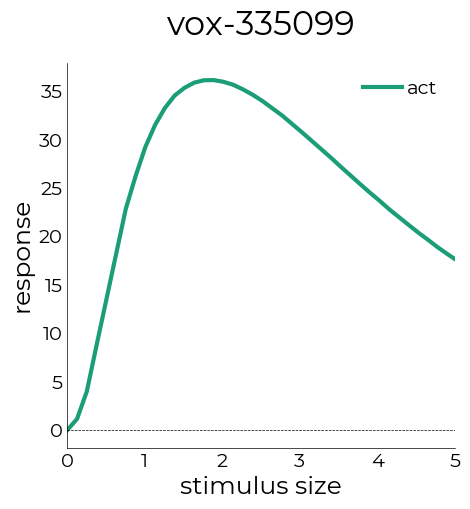

In [20]:
%matplotlib inline
fig,axs = plt.subplots(figsize=(5,5))

# plot the model fit
pars,_,tc,pred = obj.plot_vox(
    vox_nr=plot_vert, 
    make_figure=False, 
    model="norm"
)

# calculate sizeresponse
SR_ = prf.SizeResponse(params=pars, model="norm")

# size response
fill_cent, fill_cent_sizes = SR_.make_stimuli(
    factor=1,
    dt="fill"
)

sr_cent_act = SR_.batch_sr_function(
    SR_.params_df,
    center_prf=True,
    stims=fill_cent,
    sizes=fill_cent_sizes
)

plotting.LazyLine(
    sr_cent_act.iloc[:,0].values,
    xx=fill_cent_sizes,
    color="#1B9E77",
    line_width=3,
    axs=axs,
    x_label="stimulus size",
    y_label="response",
    labels=["act","suppr"],
    add_hline=0,
    title=f"vox-{plot_vert}",
    x_lim=[0,5]
)

max_dva, max_val = SR_.find_stim_sizes(
    sr_cent_act[0].values,
    t="max",
    dt="fill",
    sizes=fill_cent_sizes,
    return_ampl=True
)
print(f" Max stimulation @{round(max_dva,2)}dva | ampl = {round(max_val,2)}")

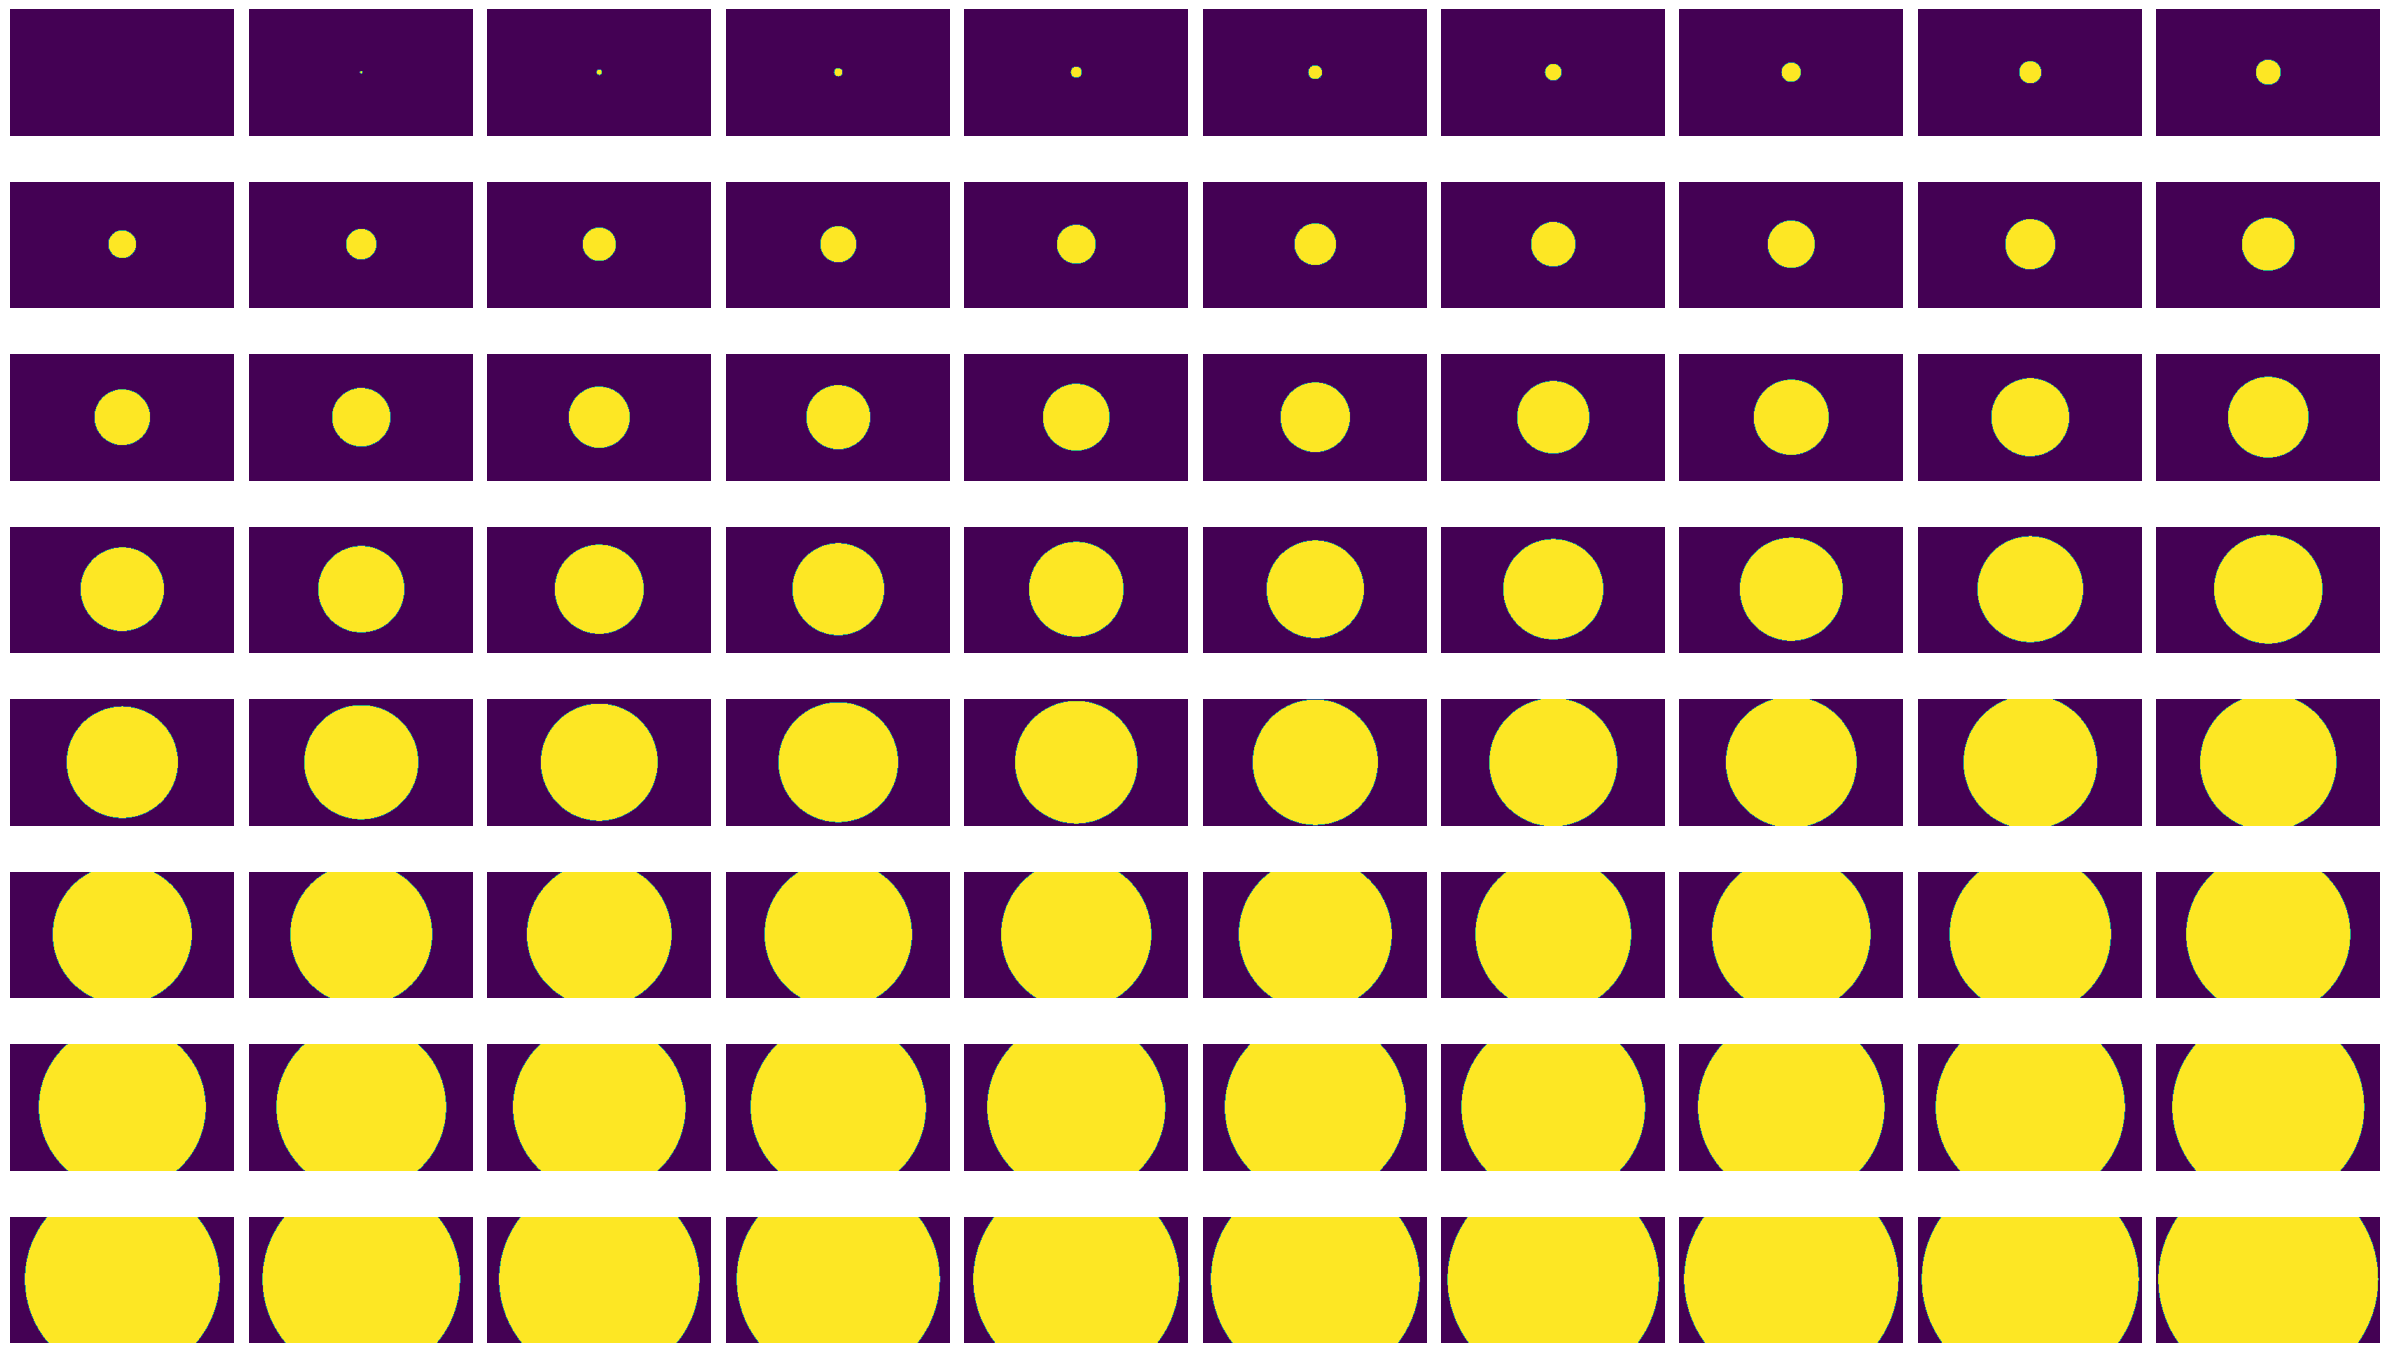

In [19]:
# plot stimuli
prf.plot_stims(fill_cent, extent=SR_.vf_extent, interval=2)